In [ ]:
# inspired by lazyprogrammer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from sklearn.preprocessing import StandardScaler


# Part 1: Price Prediction

In [ ]:
df = pd.read_csv('sbux.csv')

In [ ]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [ ]:
df.tail()

,date,open,high,low,close,volume,Name
1254,2018-02-01,56.280,56.42,55.89,56.00,14690146,SBUX
1255,2018-02-02,55.900,56.32,55.70,55.77,15358909,SBUX
1256,2018-02-05,55.530,56.26,54.57,54.69,16059955,SBUX
1257,2018-02-06,53.685,56.06,53.56,55.61,17415065,SBUX
1258,2018-02-07,55.080,55.43,54.44,54.46,13927022,SBUX


In [ ]:
# WRONG way - trying to predict the price itself

series = df['close'].values.reshape(-1, 1)

In [ ]:
scaler = StandardScaler()

scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [ ]:
# can we use T past values to predict the next value ?

T = 20
D = 1
X = []
Y = []

for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)


X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y).reshape(-1, 1)
N = len(X)


print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1239, 20, 1) Y.shape (1239, 1)


In [ ]:
### try autoregressive RNN model

class RNN(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
    super(RNN, self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    self.rnn = nn.LSTM(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        batch_first=True)
  
    self.fc = nn.Linear(self.M, self.K)
  

  def forward(self, X):
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    out, _ = self.rnn(X, (h0, c0))

    out = self.fc(out[:, -1, :]) # get h(T) at the final time step

    return out

In [ ]:
model = RNN(1, 5, 1, 1)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu").to(device)
print(device)

model

cpu


RNN(
  (rnn): LSTM(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [ ]:
def full_gd(model,
            criterion,
            optimizer,
            X_train,
            y_train,
            X_test,
            y_test,
            epochs=200):

  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    optimizer.zero_grad()

    outputs = model(X_train)
    loss = criterion(outputs, y_train)
      
    loss.backward()
    optimizer.step()

    train_losses[it] = loss.item()

    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_losses[it] = test_loss.item()
      
    if (it + 1) % 5 == 0:
      print(f'Epoch {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')
  

  return train_losses, test_losses

In [ ]:
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [ ]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [ ]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test)

Epoch 5/200, Train Loss: 0.1533, Test Loss: 0.2875
Epoch 10/200, Train Loss: 0.0513, Test Loss: 0.2019
Epoch 15/200, Train Loss: 0.0236, Test Loss: 0.0842
Epoch 20/200, Train Loss: 0.0223, Test Loss: 0.1219
Epoch 25/200, Train Loss: 0.0168, Test Loss: 0.0928
Epoch 30/200, Train Loss: 0.0136, Test Loss: 0.0910
Epoch 35/200, Train Loss: 0.0109, Test Loss: 0.1064
Epoch 40/200, Train Loss: 0.0081, Test Loss: 0.0716
Epoch 45/200, Train Loss: 0.0062, Test Loss: 0.0750
Epoch 50/200, Train Loss: 0.0056, Test Loss: 0.0560
Epoch 55/200, Train Loss: 0.0056, Test Loss: 0.0532
Epoch 60/200, Train Loss: 0.0055, Test Loss: 0.0493
Epoch 65/200, Train Loss: 0.0055, Test Loss: 0.0469
Epoch 70/200, Train Loss: 0.0054, Test Loss: 0.0466
Epoch 75/200, Train Loss: 0.0053, Test Loss: 0.0444
Epoch 80/200, Train Loss: 0.0053, Test Loss: 0.0462
Epoch 85/200, Train Loss: 0.0053, Test Loss: 0.0445
Epoch 90/200, Train Loss: 0.0052, Test Loss: 0.0460
Epoch 95/200, Train Loss: 0.0052, Test Loss: 0.0453
Epoch 100/200

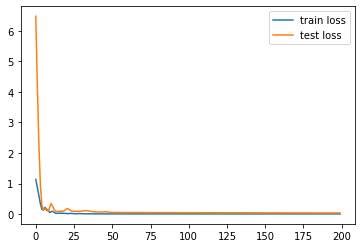

In [ ]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [ ]:
# One-step forecast using true targets

validation_target = Y
validation_predictions = []

i = 0  # index of first validation input

X_on_device = torch.from_numpy(X.astype(np.float32)).to(device)

while len(validation_predictions) < len(validation_target):
  input_ = X_on_device[i].reshape(1, T, 1)
  p = model(input_)[0,0].item() # 1x1 array -> scalar
  i += 1
  
  validation_predictions.append(p)


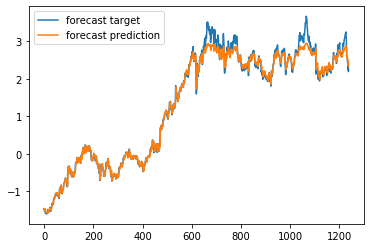

In [ ]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [ ]:
# Multi-step forecast

validation_target = Y[-N//2:]
validation_predictions = []

last_x = X_test[0].view(T)  # last train input


while len(validation_predictions) < len(validation_target):
  input_ = last_x.reshape(1, T, 1)
  p = model(input_)
  
  validation_predictions.append(p[0,0].item())  # [0,0] # 1x1 array -> scalar
  
  last_x = torch.cat((last_x[1:], p[0]))
  

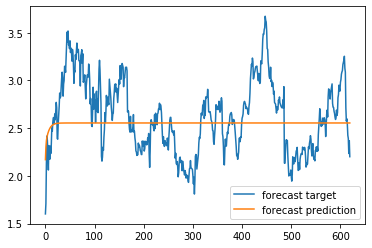

In [ ]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

# Part 2: Returns

In [ ]:
# calculate returns by first shifting the data


df['PrevClose'] = df['close'].shift(1)  # move everything up 1

# now like:-

# close / prev close
# x[2] x[1]
# x[3] x[2]
# x[4] x[3]
# ...
# x[t] x[t-1]



In [ ]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915


In [ ]:
# the return is -> (x[t] - x[t-1]) / x[t-1]

df['Return'] = (df['close'] - df['PrevClose']) / df['PrevClose']

In [ ]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose,Return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


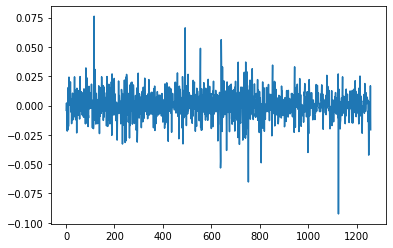

In [ ]:
plt.plot(df['Return']);

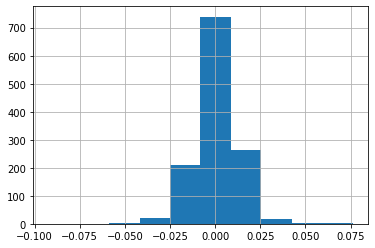

In [ ]:
df['Return'].hist()

In [ ]:
series = df['Return'].values[1:].reshape(-1, 1)


scaler = StandardScaler()

scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [ ]:
T = 20
D = 1
X = []
Y = []

for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)


X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y).reshape(-1, 1)
N = len(X)


print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1238, 20, 1) Y.shape (1238, 1)


In [ ]:
model = RNN(1, 5, 1, 1).to(device)
model

RNN(
  (rnn): LSTM(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [ ]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [ ]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test)

Epoch 5/200, Train Loss: 1.0666, Test Loss: 1.0724
Epoch 10/200, Train Loss: 1.0527, Test Loss: 1.0909
Epoch 15/200, Train Loss: 1.0557, Test Loss: 1.0907
Epoch 20/200, Train Loss: 1.0484, Test Loss: 1.0770
Epoch 25/200, Train Loss: 1.0476, Test Loss: 1.0735
Epoch 30/200, Train Loss: 1.0461, Test Loss: 1.0746
Epoch 35/200, Train Loss: 1.0427, Test Loss: 1.0791
Epoch 40/200, Train Loss: 1.0401, Test Loss: 1.0858
Epoch 45/200, Train Loss: 1.0374, Test Loss: 1.0897
Epoch 50/200, Train Loss: 1.0346, Test Loss: 1.0920
Epoch 55/200, Train Loss: 1.0327, Test Loss: 1.0969
Epoch 60/200, Train Loss: 1.0312, Test Loss: 1.1038
Epoch 65/200, Train Loss: 1.0300, Test Loss: 1.1083
Epoch 70/200, Train Loss: 1.0286, Test Loss: 1.1085
Epoch 75/200, Train Loss: 1.0272, Test Loss: 1.1080
Epoch 80/200, Train Loss: 1.0258, Test Loss: 1.1086
Epoch 85/200, Train Loss: 1.0244, Test Loss: 1.1095
Epoch 90/200, Train Loss: 1.0229, Test Loss: 1.1113
Epoch 95/200, Train Loss: 1.0212, Test Loss: 1.1132
Epoch 100/200

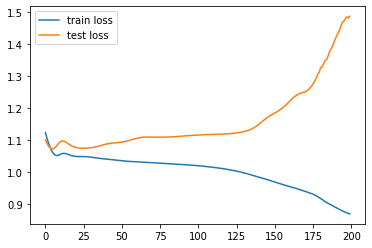

In [ ]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [ ]:
# One-step forecast using true targets

validation_target = Y
validation_predictions = []

i = 0  # index of first validation input

X_on_device = torch.from_numpy(X.astype(np.float32)).to(device)

while len(validation_predictions) < len(validation_target):
  input_ = X_on_device[i].reshape(1, T, 1)
  p = model(input_)[0,0].item()  # 1x1 array -> scalar
  i += 1
  
  validation_predictions.append(p)


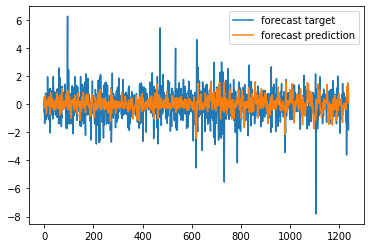

In [ ]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [ ]:
# Multi-step forecast

validation_target = Y[-N//2:]
validation_predictions = []

last_x = X_test[0].view(T)  # last train input

while len(validation_predictions) < len(validation_target):
  input_ = last_x.reshape(1, T, 1)
  p = model(input_)
  
  validation_predictions.append(p[0,0].item())  # [0,0] # 1x1 array -> scalar
  
  last_x = torch.cat((last_x[1:], p[0]))
  

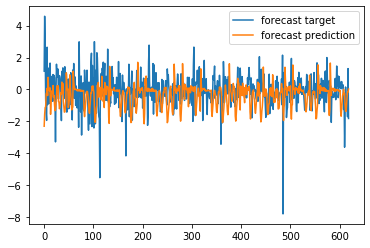

In [ ]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

# Part 3: Binary Classification

In [ ]:
# turn the full data into numpy arrays, not yet in the final format

input_data = df[['open', 'high', 'low', 'close', 'volume']].values
targets = df['Return'].values

In [ ]:
T = 10  # the number of time steps to look at to make a prediction for the next day

D = input_data.shape[1]

N = len(input_data) - T # (e.g. if T=10 and there are 11 data points then we'd only have 1 sample)

In [ ]:
Ntrain = len(input_data) * 2 // 3


scaler = StandardScaler()

scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

In [ ]:
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros((Ntrain, 1))

for t in range(Ntrain):
  X_train[t, :, :] = input_data[t:t+T]
  Y_train[t] = (targets[t+T] > 0)

In [ ]:
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros((N - Ntrain, 1))


for u in range(N - Ntrain):    # u counts from 0...(N - Ntrain)
  
  t = u + Ntrain  # t counts from Ntrain...N
  
  X_test[u, :, :] = input_data[t:t+T]
  Y_test[u] = (targets[t+T] > 0)



In [ ]:
model = RNN(5, 50, 2, 1).to(device)
model

RNN(
  (rnn): LSTM(5, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [ ]:
# it's classification now

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(Y_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(Y_test.astype(np.float32))

In [ ]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [ ]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test,
                                    epochs=300)

Epoch 5/300, Train Loss: 0.6917, Test Loss: 0.6930
Epoch 10/300, Train Loss: 0.6915, Test Loss: 0.6936
Epoch 15/300, Train Loss: 0.6898, Test Loss: 0.6913
Epoch 20/300, Train Loss: 0.6860, Test Loss: 0.6925
Epoch 25/300, Train Loss: 0.6830, Test Loss: 0.7031
Epoch 30/300, Train Loss: 0.6794, Test Loss: 0.7024
Epoch 35/300, Train Loss: 0.6727, Test Loss: 0.7206
Epoch 40/300, Train Loss: 0.6663, Test Loss: 0.7369
Epoch 45/300, Train Loss: 0.6622, Test Loss: 0.7610
Epoch 50/300, Train Loss: 0.6486, Test Loss: 0.7806
Epoch 55/300, Train Loss: 0.6330, Test Loss: 0.7904
Epoch 60/300, Train Loss: 0.6125, Test Loss: 0.8240
Epoch 65/300, Train Loss: 0.5842, Test Loss: 0.9422
Epoch 70/300, Train Loss: 0.5465, Test Loss: 1.0212
Epoch 75/300, Train Loss: 0.5248, Test Loss: 1.0939
Epoch 80/300, Train Loss: 0.4848, Test Loss: 1.1769
Epoch 85/300, Train Loss: 0.4510, Test Loss: 1.2732
Epoch 90/300, Train Loss: 0.4160, Test Loss: 1.3699
Epoch 95/300, Train Loss: 0.3899, Test Loss: 1.4148
Epoch 100/300

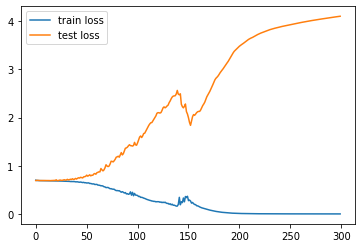

In [ ]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [ ]:
with torch.no_grad():
  p_train = model(X_train)
  p_train = (p_train.cpu().numpy() > 0)
  train_acc = np.mean(y_train.cpu().numpy() == p_train)

  p_test = model(X_test)
  p_test = (p_test.cpu().numpy() > 0)
  test_acc = np.mean(y_test.cpu().numpy() == p_test)

print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 1.0000, Test acc: 0.4902
